In [5]:
# only run if you need to split dataset
!pip install split-folders
import splitfolders

# Importing libraries and preparing paths

In [8]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [96]:
import os
import cv2
import platform
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sb
import shutil
import glob 
import skimage
from skimage import io 
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import tensorflow as tf
%matplotlib inline

In [ ]:
os.mkdir("/content/complete_dataset")

In [97]:
# path to save kaggle api numbers
kaggle_dir = "/content/drive/MyDrive/kaggle"
# path to the dataset on google drive
dataset_drive_dir= "/content/drive/MyDrive/dataset"
# path of balanced dataset on colab
balanced_data_dir = "/content/complete_dataset/balanced_dataset"
# path to images on drive after balancing
balanced_data_img_dir_drive = dataset_drive_dir + "/images"
# path to images on drive ready for glob
images_path = balanced_data_img_dir_drive + "/balanced_dataset/"
resized_images_path = dataset_drive_dir + "/resized_images/"
# path to csv on drive after balancing
balanced_data_csv_dir_drive = dataset_drive_dir + "/csv_folder/"
# path to balanced csv on colab
balanced_csv_dir = "/content/complete_dataset/balanced_metadata.csv"
# path to folder of train before balancing
train_path = "/content/complete_dataset/train"
# path to text metadata
# upload train_COVIDx9A.txt and test_COVIDx9A.txt to this path
train9A_text_dir = "/content/complete_dataset/train_COVIDx9A.txt"
test9A_text_dir = "/content/complete_dataset/test_COVIDx9A.txt"

# datasetV2
dataset_v2 = "/content/drive/MyDrive/DatasetV2"
dataset_v2_classes = dataset_v2 + "/classes"
dataset_v2_split = dataset_v2 + "/split_images"
# path to checkpoint on drive
checkpoint_path = "/content/drive/MyDrive/DatasetV2/model/checkpoints/"

In [ ]:
os.mkdir(balanced_data_dir)
os.mkdir(balanced_data_img_dir_drive)
os.mkdir(balanced_data_csv_dir_drive)
os.mkdir(checkpoint_path)

# Drive and downloading data from kaggle

In [ ]:
!pip install kaggle

In [ ]:
!cp $kaggle_dir "/content"

cp: -r not specified; omitting directory '/content/drive/MyDrive/kaggle'


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/kaggle'

In [ ]:
%cd '/content/kaggle'

/content/kaggle


In [ ]:
!kaggle datasets download -d andyczhao/covidx-cxr2

100% 12.9G/12.9G [01:37<00:00, 210MB/s]
100% 12.9G/12.9G [01:37<00:00, 143MB/s]


In [ ]:
!unzip "/content/kaggle/covidx-cxr2.zip" -d "/content/complete_dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/complete_dataset/train/aead3682-bdf4-4f43-8468-8e6ac3cd41fa.png  
  inflating: /content/complete_dataset/train/aeae6cbc-d713-4760-845c-fcc93ed5ad64.png  
  inflating: /content/complete_dataset/train/aeaf6ffd-ff7e-48cc-b31f-175a5e79b415.png  
  inflating: /content/complete_dataset/train/aeb2a32c-595a-44c2-b827-c6ce0f6ff4f3.png  
  inflating: /content/complete_dataset/train/aeb6324d-08d5-426b-9a60-bc39d5151edb.png  
  inflating: /content/complete_dataset/train/aeb99fe0-d9f2-4122-8abf-e7f933f71f80.png  
  inflating: /content/complete_dataset/train/aebb48db-2f6f-41ad-87e7-d90c5620187e.png  
  inflating: /content/complete_dataset/train/aebb5625-cbea-4e11-9a9a-19708903ed1b.png  
  inflating: /content/complete_dataset/train/aebf9717-f500-44ac-87cd-273f24e0c3ce.png  
  inflating: /content/complete_dataset/train/aec1daa4-1910-4270-8de2-9abe6f3b1bf0.png  
  inflating: /content/complete_dataset/train/aec5b2e5-ceff-4e21-a089-

# Data preperation

In [ ]:
def findfile(name, path):
    for dirpath, dirname, filename in os.walk(path):
        if name in filename:
            return os.path.join(dirpath, name)

In [ ]:
train_file = pd.read_csv(train9A_text_dir, header=None, sep=' ')

In [ ]:
train_file.head()

,0,1,2,3
0,3,SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0....,pneumonia,cohen
1,3,SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5....,pneumonia,cohen
2,3,SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10...,pneumonia,cohen
3,7,SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day...,pneumonia,cohen
4,7,SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day...,pneumonia,cohen


In [ ]:
train_file.tail()

,0,1,2,3
30125,55204bb8-89fc-449d-8563-e91654abea9d,55204bb8-89fc-449d-8563-e91654abea9d.png,normal,rnsa
30126,0f4b80b6-fd39-451f-aebf-7cdb1b655c0b,0f4b80b6-fd39-451f-aebf-7cdb1b655c0b.png,normal,rnsa
30127,5fb64e85-62ef-4852-8ad1-f799015c8cc3,5fb64e85-62ef-4852-8ad1-f799015c8cc3.png,normal,rnsa
30128,c57ad4fd-3aa8-4ae8-a262-7336360d8265,c57ad4fd-3aa8-4ae8-a262-7336360d8265.png,normal,rnsa
30129,c56b4527-615d-414f-a375-081e6f3bbfdc,c56b4527-615d-414f-a375-081e6f3bbfdc.png,normal,rnsa


In [ ]:
test_file = pd.read_csv(test9A_text_dir, header=None, sep=' ')

In [ ]:
test_file.head()

,0,1,2,3
0,419639-003251,MIDRC-RICORD-1C-419639-003251-46647-0.png,COVID-19,ricord
1,419639-001464,MIDRC-RICORD-1C-419639-001464-39871-0.png,COVID-19,ricord
2,419639-000918,MIDRC-RICORD-1C-419639-000918-78965-0.png,COVID-19,ricord
3,419639-003318,MIDRC-RICORD-1C-419639-003318-64285-0.png,COVID-19,ricord
4,419639-001015,MIDRC-RICORD-1C-419639-001015-81591-0.png,COVID-19,ricord


In [ ]:
test_file.tail()

,0,1,2,3
395,a77b32f6-1999-4cc6-8a0d-1ef7e53850f0,a77b32f6-1999-4cc6-8a0d-1ef7e53850f0.png,pneumonia,rsna
396,41bf2042-53a2-44a8-9a29-55e643af5ac0,41bf2042-53a2-44a8-9a29-55e643af5ac0.png,pneumonia,rsna
397,ec09ddb3-9b0b-4749-9e0d-f94a4a7e5fed,ec09ddb3-9b0b-4749-9e0d-f94a4a7e5fed.png,pneumonia,rsna
398,abff4044-3c0a-458f-b0c7-04254be7fc0c,abff4044-3c0a-458f-b0c7-04254be7fc0c.png,pneumonia,rsna
399,27b32500-40ef-4c14-ab88-ace5e9ceea27,27b32500-40ef-4c14-ab88-ace5e9ceea27.png,pneumonia,rsna


In [ ]:
data = train_file.sample(n=3000, replace=False,  random_state=5, axis=0)

In [ ]:
data.head()

,0,1,2,3
8348,d37fe302-4cd1-46ad-9981-09e1b62eafaf,d37fe302-4cd1-46ad-9981-09e1b62eafaf.png,normal,rsna
23565,A832393,A832393-02-08-1901-NA-CHEST_AP_PORT-43020-3.00...,COVID-19,stonybrook
4751,6aef6ac2-01b9-4742-ad26-429cc9577a1f,6aef6ac2-01b9-4742-ad26-429cc9577a1f.png,normal,rsna
27745,A599118,A599118-12-31-1900-NA-CHEST_AP_VIEWONLY-40989-...,COVID-19,stonybrook
24473,A735418,A735418-12-31-1900-NA-CHEST_AP_VIEWONLY-12061-...,COVID-19,stonybrook


In [ ]:
data.tail()

,0,1,2,3
11648,55bf665e-e53b-4320-baa7-4fdaa54447db,55bf665e-e53b-4320-baa7-4fdaa54447db.png,pneumonia,rsna
9339,ee9c1ee7-38c3-45f0-ac3b-5bdda1fc4223,ee9c1ee7-38c3-45f0-ac3b-5bdda1fc4223.png,normal,rsna
9217,ea872d0d-d42c-4330-9c09-799bc3b0ab09,ea872d0d-d42c-4330-9c09-799bc3b0ab09.png,normal,rsna
9442,f23ba6fa-6625-4b77-9d81-332e5091b50d,f23ba6fa-6625-4b77-9d81-332e5091b50d.png,normal,rsna
3883,549f95a2-c418-4414-b822-f4c9447cf87b,549f95a2-c418-4414-b822-f4c9447cf87b.png,normal,rsna


In [ ]:
is_covid_train = train_file[2]=="COVID-19"
covid_train = train_file[is_covid_train]
print(covid_train.shape)

# Filter txt with type "pneumonia"
is_pneumonia_train = train_file[2]=="pneumonia"
pneumonia_train = train_file[is_pneumonia_train]
print(pneumonia_train.shape)

# Filter txt with type "normal"
is_normal_train = train_file[2]=="normal"
normal_train = train_file[is_normal_train]
print(normal_train.shape)

(16490, 4)
(5555, 4)
(8085, 4)


In [ ]:
is_covid_test = test_file[2]=="COVID-19"
covid_test = test_file[is_covid_test]
print(covid_test.shape)

# Filter txt with type "pneumonia"
is_pneumonia_test = test_file[2]=="pneumonia"
pneumonia_test = test_file[is_pneumonia_test]
print(pneumonia_test.shape)

# Filter txt with type "normal"
is_normal_test = test_file[2]=="normal"
normal_test = test_file[is_normal_test]
print(normal_test.shape)

(200, 4)
(100, 4)
(100, 4)


In [ ]:
#balance data
train_covid_data = covid_train.sample(n=1000, replace=False,  random_state=10, axis=0)

In [ ]:
train_pneumonia_data = pneumonia_train.sample(n=1000, replace=False,  random_state=10, axis=0)

In [ ]:
train_normal_data = normal_train.sample(n=1000, replace=False,  random_state=10, axis=0)

In [ ]:
is_covid_test = test_file[2]=="COVID-19"
covid_test = test_file[is_covid_test]
covid_test = covid_test.sample(n=100, replace=False,  random_state=10, axis=0)
print(covid_test.shape)

# Filter txt with type "pneumonia"
is_pneumonia_test = test_file[2]=="pneumonia"
pneumonia_test = test_file[is_pneumonia_test]
print(pneumonia_test.shape)

# Filter txt with type "normal"
is_normal_test = test_file[2]=="normal"
normal_test = test_file[is_normal_test]
print(normal_test.shape)

(100, 4)
(100, 4)
(100, 4)


In [ ]:
for row in train_covid_data.iterrows():
  print(row[1][1])
  imagePath = findfile(row[1][1], train_path)
  shutil.move(imagePath, balanced_data_dir)

A438102-02-26-1901-NA-CHEST_AP_PORT-83353-3.000000-AP-93897-1-1.jpg
A727037-01-11-1901-NA-FLAT_PLATE_OF_ABDOMEN_PORTABLE-57043-1.000000-AP-87870-1-1.jpg
A349708-01-07-1901-NA-CHEST_AP_PORT-22302-1.000000-AP-79636-1-1.jpg
A000801-01-12-1901-NA-CHEST_AP_PORT-14997-5.000000-AP-14739-1-1.jpg
A237090-12-31-1900-NA-CHEST_AP_PORT-21070-2.000000-AP-14492-1-1.jpg
MIDRC-RICORD-1C-419639-000800-40610-0.png
A832393-01-23-1901-NA-CHEST_AP_PORT_CENTRAL_LINE_PL-05921-3.000000-AP-18197-1-1.jpg
A403529-01-18-1901-NA-CHEST_AP_PORT-32871-5.000000-AP-41943-1-1.jpg
A727037-02-04-1901-NA-CHEST_AP_PORT-53464-2.000000-AP-89688-1-1.jpg
COVID(792).png
A880343-01-19-1901-NA-CHEST_AP_VIEWONLY-88653-3.000000-AP-33092-1-1.jpg
A656088-12-31-1900-NA-CHEST_AP_VIEWONLY-53965-1.000000-AP-32022-1-1.jpg
A416909-02-06-1901-NA-CHEST_AP_PORT-78549-2.000000-AP-86161-1-1.jpg
A882175-01-15-1901-NA-CHEST_AP_PORT-87084-1.000000-AP-26551-1-1.jpg
A347680-02-03-1901-NA-FLAT_PLATE_OF_ABDOMEN_PORTABLE-00280-7.000000-AP-98270-1-1.jpg
A

In [ ]:
for row in train_pneumonia_data.iterrows():
  print(row[1][1])
  imagePath = findfile(row[1][1], train_path)
  shutil.move(imagePath, balanced_data_dir)

6a41e296-8bda-4f84-8766-c253246b77d0.png
cf7e865e-f0b1-4a22-8508-f0636247f895.png
afe0a0c8-878e-48b9-bcd8-48526125fcdb.png
0409b97f-7673-42e2-9943-0656c6aaca69.png
82054420-6a12-4690-ae52-9d3be158499c.png
ab6f5973-db3c-4c21-8981-189792ea16ee.png
8502b7bb-f681-47a1-aa45-06f6b692841a.png
bff6b953-95d1-4a08-9d79-c3b43fde59ce.png
388cc388-c2aa-4bfe-8a63-4565c626d951.png
0d77cf1a-64d4-4f8a-938b-9b838d549090.png
2a37f773-2855-4765-989e-0991de60bd0c.png
ca8b395d-7ca0-4dc4-8b56-ff519b4edb89.png
a410dbbd-1ee8-4b79-876e-200b093b0e43.png
a6a420f8-b676-49e1-9273-fd1b9f9fdfc9.png
b6276787-bf66-4151-9f7a-b3d7fdf5ae30.png
5b0c3016-c88d-4b19-82f8-bee204b8e12c.png
361c09b7-beb1-4be9-bb4b-c6400c293a19.png
4fabf46a-ceec-421c-bb64-8527b44aa576.png
c3a5e685-166b-4f22-b9bb-151a0040e0ee.png
36042724-581b-4459-a45a-603beec0bdf2.png
dd400306-5e55-42d5-8177-673d1e207600.png
106e39b9-9ca8-4437-b7f9-f114fd3aec61.png
9def0034-2612-4df3-9fa9-d5677dbae95e.png
0f3ac29b-7682-4402-bbe5-89e4add87639.png
be03b6e9-e030-44

In [ ]:
for row in train_normal_data.iterrows():
  print(row[1][1])
  imagePath = findfile(row[1][1], train_path)
  shutil.move(imagePath, balanced_data_dir)

92bf6e36-702f-4cb8-b345-7769295e900f.png
545ef4ff-a6c7-40b6-bc2a-34e71c758909.png
34af7b68-8982-4bfd-bd8a-af266418906c.png
9f8586c1-b803-4eb3-8d27-61e7cec5db11.png
a60fb9ac-c843-4f96-9eb0-6fd0565ffcd5.png
eeb5c42b-5e05-496e-9662-23e745714d49.png
0b0860dc-b2ca-4016-a6eb-3a88ffb5ab2a.png
d393adf2-8a12-4ded-a842-6e4f4289fcc1.png
96cdbb89-1bda-4ec1-91d5-fe27d8ddd727.png
e6d643f9-3a71-47bd-ba97-90912b918c65.png
d75bba61-b5c7-4d8e-a97b-0550a6de2f01.png
3dd1b743-1aa3-44af-8bfd-5d02e988a7e1.png
9addd7f0-dd54-47db-b70e-bc9baffe2b14.png
4f9a7303-4d5d-45fc-bcc4-d3f50f03464e.png
a9640dbb-05f9-462c-85ec-8fefecd9a235.png
e9b7cd5d-3d54-48d4-a784-8abae7369366.png
7a1faa41-252e-44d2-b019-63ebc8dd4ee2.png
08cbc4cf-9efb-47e4-a77f-d734e6a273c5.png
cedc0cde-789d-4a63-9778-b57cffba2d94.png
765f5d41-e660-4b45-97ed-0eb22390b720.png
6d92b74d-4fea-418a-8e02-1e430331e99c.png
ac23be83-8423-4e72-a365-3df113da4de4.png
87c025b9-0f2d-45cc-8d7a-bf6a7f817d15.png
e504d475-977b-4668-b23c-154100f89fa7.png
a705f22a-c348-44

In [ ]:
!mv $balanced_data_dir $balanced_data_img_dir_drive

In [ ]:
cp_train_covid_data = train_covid_data
cp_train_pneumonia_data = train_pneumonia_data
cp_train_normal_data = train_normal_data

In [ ]:
balanced_csv = pd.concat([cp_train_covid_data, cp_train_pneumonia_data, cp_train_normal_data])

In [ ]:
balanced_csv.to_csv(balanced_csv_dir)

In [ ]:
!mv $balanced_csv_dir $balanced_data_csv_dir_drive

# Data preprocessing

In [ ]:
def get_images_names(path):
  name_list = []
  i = 0
  for dirpath, dirname, filenames in os.walk(path):
    for filename in filenames:
      name_list.append(filename)
      i = i + 1
  return name_list

In [ ]:
images_names = get_images_names(images_path)

In [ ]:
print(len(images_names))

3000


In [ ]:
class_names = ['COVID-19', 'pneumonia', 'normal']
# apply glob module to retrieve image paths  

print(images_path)
images_path = glob.glob(images_path+"*")
print(images_path)
print(resized_images_path)

/content/drive/MyDrive/dataset/images/balanced_dataset/
['/content/drive/MyDrive/dataset/images/balanced_dataset/000003.jpg', '/content/drive/MyDrive/dataset/images/balanced_dataset/000004.jpg', '/content/drive/MyDrive/dataset/images/balanced_dataset/000004.png', '/content/drive/MyDrive/dataset/images/balanced_dataset/000012-3.jpg', '/content/drive/MyDrive/dataset/images/balanced_dataset/000924cf-0f8d-42bd-9158-1af53881a557.png', '/content/drive/MyDrive/dataset/images/balanced_dataset/000db696-cf54-4385-b10b-6b16fbb3f985.png', '/content/drive/MyDrive/dataset/images/balanced_dataset/0025d2de-bd78-4d36-9f72-e15a5e22ca82.png', '/content/drive/MyDrive/dataset/images/balanced_dataset/0053ee32-1e03-4dc2-a103-f46ad0448787.png', '/content/drive/MyDrive/dataset/images/balanced_dataset/00704310-78a8-4b38-8475-49f4573b2dbb.png', '/content/drive/MyDrive/dataset/images/balanced_dataset/0087bd3a-55a7-4045-b111-b018fa52d361.png', '/content/drive/MyDrive/dataset/images/balanced_dataset/00aecb01-a116-4

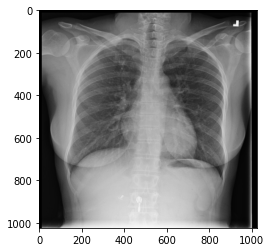

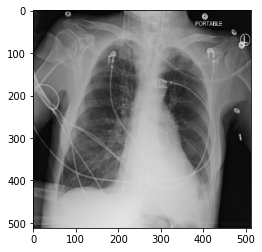

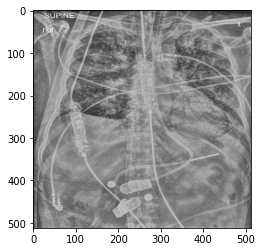

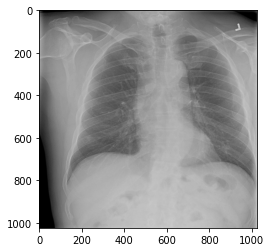

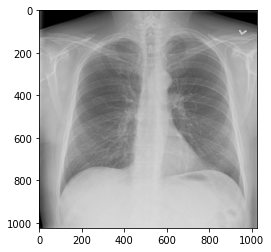

In [ ]:
#show examples before preprocessing
for c in range(5):
  image = io.imread(images_path[random.randint(1, len(images_names))])
  # plotting the original image
  i, (im1) = plt.subplots(1)
  i.set_figwidth(15)
  im1.imshow(image, cmap = 'gray')

In [ ]:
# loop throught image paths
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
counter = 0
for image_path in images_path:
  #read image
  img = io.imread(image_path)
  # convert image to greyscale
  gray_image = skimage.color.rgb2gray(img)
  # normalize pixel intensity of image
  #norm_image = (gray_image - np.min(gray_image)) / (np.max(gray_image) - np.min(gray_image))
  # save normalized image
  io.imsave(image_path, gray_image)
  # resize image
  resized_img = tf.keras.preprocessing.image.load_img(image_path, target_size=(200, 200))
  # convert resized image to numpy array because imsave doesn't handle pil
  resized_img = np.array(resized_img)
  # save resized image
  io.imsave(resized_images_path+images_names[counter], resized_img)
  shutil.move(image_path, "/content")
  counter = counter + 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  if __name__ == '__main__':


In [ ]:
images_names = get_images_names(resized_images_path)
print(len(images_names))

3000


In [ ]:
resized_images_path = glob.glob(resized_images_path+"*")

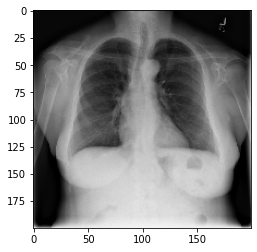

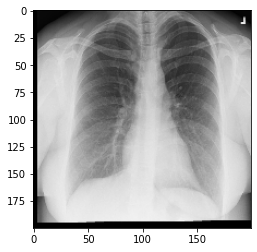

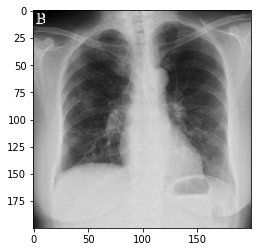

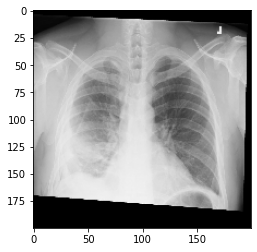

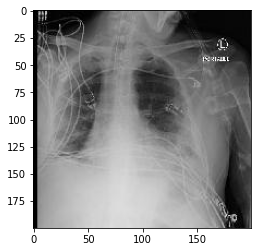

In [ ]:
for c in range(5):
  image = io.imread(resized_images_path[random.randint(0, 2999)])
  # plotting the original image
  i, (im1) = plt.subplots(1)
  i.set_figwidth(15)
  im1.imshow(image)

# Data split

In [ ]:
metadata = pd.read_csv(dataset_v2+"/balanced_metadata.csv")
print(type(metadata))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
metadata.head()

,Unnamed: 0,0,1,2,3
0,18968,A438102,A438102-02-26-1901-NA-CHEST_AP_PORT-83353-3.00...,COVID-19,stonybrook
1,23924,A727037,A727037-01-11-1901-NA-FLAT_PLATE_OF_ABDOMEN_PO...,COVID-19,stonybrook
2,17590,A349708,A349708-01-07-1901-NA-CHEST_AP_PORT-22302-1.00...,COVID-19,stonybrook
3,24012,A000801,A000801-01-12-1901-NA-CHEST_AP_PORT-14997-5.00...,COVID-19,stonybrook
4,18173,A237090,A237090-12-31-1900-NA-CHEST_AP_PORT-21070-2.00...,COVID-19,stonybrook


In [ ]:
metadata.columns = ['patient id', 'image id' , 'filename', 'class', 'data source']

In [ ]:
metadata.head()

,patient id,image id,filename,class,data source
0,18968,A438102,A438102-02-26-1901-NA-CHEST_AP_PORT-83353-3.00...,COVID-19,stonybrook
1,23924,A727037,A727037-01-11-1901-NA-FLAT_PLATE_OF_ABDOMEN_PO...,COVID-19,stonybrook
2,17590,A349708,A349708-01-07-1901-NA-CHEST_AP_PORT-22302-1.00...,COVID-19,stonybrook
3,24012,A000801,A000801-01-12-1901-NA-CHEST_AP_PORT-14997-5.00...,COVID-19,stonybrook
4,18173,A237090,A237090-12-31-1900-NA-CHEST_AP_PORT-21070-2.00...,COVID-19,stonybrook


In [ ]:
metadata = metadata.drop(['patient id', 'image id', 'data source'], axis = 1)

In [ ]:
metadata.head()

,filename,class
0,A438102-02-26-1901-NA-CHEST_AP_PORT-83353-3.00...,COVID-19
1,A727037-01-11-1901-NA-FLAT_PLATE_OF_ABDOMEN_PO...,COVID-19
2,A349708-01-07-1901-NA-CHEST_AP_PORT-22302-1.00...,COVID-19
3,A000801-01-12-1901-NA-CHEST_AP_PORT-14997-5.00...,COVID-19
4,A237090-12-31-1900-NA-CHEST_AP_PORT-21070-2.00...,COVID-19


In [ ]:
metadata['class'].value_counts()

COVID-19     1000
pneumonia    1000
normal       1000
Name: class, dtype: int64

Old data split

In [ ]:
train_df, test_df = train_test_split(metadata, train_size = 0.8, random_state = 10)

In [ ]:
print(train_df.shape)
print(train_df['class'].value_counts())
train_df.head()

(2400, 2)
normal       818
COVID-19     798
pneumonia    784
Name: class, dtype: int64


,filename,class
2592,7a39e982-e5f1-402c-b9a8-b9ee5f43fb8c.png,normal
87,A626547-12-31-1900-NA-CHEST_AP_VIEWONLY-78783-...,COVID-19
729,A466263-01-04-1901-NA-CHEST_AP_PORT-11120-2.00...,COVID-19
1065,49b96a4d-7bfb-49f2-a31f-932371038652.png,pneumonia
1998,3b66da46-f0a2-4e41-bd6d-68a8ba799708.png,pneumonia


In [ ]:
print(test_df.shape)
print(test_df['class'].value_counts())
test_df.head()

(600, 2)
pneumonia    216
COVID-19     202
normal       182
Name: class, dtype: int64


,filename,class
1779,ba06c828-df8c-4c6f-a869-b3ea7d1991cd.png,pneumonia
341,MIDRC-RICORD-1C-SITE2-000123-76427-0.png,COVID-19
1276,6fe4d086-05ee-4b7c-887b-58954b0c5e6d.png,pneumonia
1012,a410dbbd-1ee8-4b79-876e-200b093b0e43.png,pneumonia
470,A601967-01-01-1901-NA-CHEST_AP_PORT_CENTRAL_LI...,COVID-19


In [ ]:
train_df, val_df = train_test_split(train_df, train_size = 0.8, random_state = 10)

In [ ]:
print(train_df.shape)
print(train_df['class'].value_counts())
train_df.head()

(1920, 2)
normal       655
pneumonia    639
COVID-19     626
Name: class, dtype: int64


,filename,class
886,A851902-01-04-1901-NA-CHEST_AP_PORT-77158-2.00...,COVID-19
266,A222465-01-02-1901-NA-CHEST_AP_PORT-77369-1.00...,COVID-19
1507,9bf4af74-aba7-41ef-9606-b19bf8526a72.png,pneumonia
250,A403529-01-18-1901-NA-CHEST_AP_PORT-28143-4.00...,COVID-19
367,A454725-12-31-1900-NA-CHEST_AP_PORT-92913-1.00...,COVID-19


In [ ]:
print(val_df.shape)
print(val_df['class'].value_counts())
val_df.head()

(480, 2)
COVID-19     172
normal       163
pneumonia    145
Name: class, dtype: int64


,filename,class
2775,ac3e7d5f-a894-4b41-9ea3-1645c4c647f5.png,normal
1120,aac0f44c-3942-460a-8d75-ece0ac88ab0f.png,pneumonia
451,A403529-01-15-1901-NA-CHEST_AP_PORT-85376-6.00...,COVID-19
179,MIDRC-RICORD-1C-SITE2-000133-60930-0.png,COVID-19
1666,03d92597-3e33-4fdf-8db5-a27cf5b8d3eb.png,pneumonia


In [ ]:
datagen = ImageDataGenerator()

In [ ]:
train_gen = datagen.flow_from_dataframe(dataframe = train_df, directory="/content/", x_col='filename', y_col='class', class_mode='categorical', taregt_size = (200,200))

Found 1920 validated image filenames belonging to 3 classes.


In [ ]:
val_gen = datagen.flow_from_dataframe(dataframe = val_df, directory="/content/", x_col='filename', y_col='class',  class_mode='categorical', taregt_size = (200,200))

Found 480 validated image filenames belonging to 3 classes.


In [ ]:
test_gen = datagen.flow_from_dataframe(dataframe = test_df, directory="/content/", x_col='filename', y_col='class',  class_mode='categorical', taregt_size = (200,200))

Found 600 validated image filenames belonging to 3 classes.


In [ ]:
train_gen.get_classes(train_df, y_col = 'class')

In [ ]:
# split images into train text val sith subdirectries of classes
def split_images(path, dst, split):
  image_name = get_images_names(path)
  print(len(image_name))
  for image in image_name:
    for row in metadata.iterrows():
      if row[1][0] == image:
        shutil.move(path+image, dst+row[1][1]+'/')
  splitfolders.ratio(dst, output=split, seed=1337, ratio=(.8, 0.2,0.2))

In [101]:
batch_size = 32

In [102]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_v2_split + "/train",
  image_size=(200, 200),
  batch_size=batch_size,
  label_mode="categorical",
  seed = 1000
  )
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_v2_split + "/val",
  image_size=(200, 200),
  batch_size=batch_size,
  label_mode="categorical",
  seed = 1000
  )
test_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_v2_split + "/test",
  image_size=(200, 200),
  batch_size=batch_size,
  label_mode="categorical",
  seed = 1000
  )

Found 1800 files belonging to 3 classes.
Found 900 files belonging to 3 classes.
Found 600 files belonging to 3 classes.


# Model

In [103]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax', name='predictions'))

In [104]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 batch_normalization_60 (Bat  (None, 198, 198, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 99, 99, 32)       0         
 g2D)                                                            
                                                                 
 dropout_60 (Dropout)        (None, 99, 99, 32)        0         
                                                                 
 conv2d_51 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 batch_normalization_61 (Bat  (None, 97, 97, 64)     

In [105]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=20, mode="max", restore_best_weights=True)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', 
                                            patience = 20, 
                                            verbose = 1, 
                                            factor = 0.5, 
                                            min_lr = 0.00001,
                                            mode = "min")
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path+'model.h5', monitor="val_accuracy", mode="max",	save_best_only=True, verbose=1)
callbacks = [earlystop, learning_rate_reduction, checkpoint]

# Training

In [106]:
history = model.fit(  
    train_ds, 
    epochs = 100,
    validation_data = val_ds,
    callbacks = callbacks
)

Epoch 1/100
56/57 [============================>.] - ETA: 0s - loss: 1.2466 - accuracy: 0.5921
Epoch 1: val_accuracy improved from -inf to 0.37333, saving model to /content/drive/MyDrive/DatasetV2/model/checkpoints/model.h5
57/57 [==============================] - 31s 478ms/step - loss: 1.2513 - accuracy: 0.5917 - val_loss: 2.1491 - val_accuracy: 0.3733 - lr: 0.0010
Epoch 2/100
56/57 [============================>.] - ETA: 0s - loss: 0.9940 - accuracy: 0.6473
Epoch 2: val_accuracy improved from 0.37333 to 0.43889, saving model to /content/drive/MyDrive/DatasetV2/model/checkpoints/model.h5
57/57 [==============================] - 29s 473ms/step - loss: 0.9925 - accuracy: 0.6478 - val_loss: 1.7118 - val_accuracy: 0.4389 - lr: 0.0010
Epoch 3/100
56/57 [============================>.] - ETA: 0s - loss: 0.8444 - accuracy: 0.6791
Epoch 3: val_accuracy improved from 0.43889 to 0.69667, saving model to /content/drive/MyDrive/DatasetV2/model/checkpoints/model.h5
57/57 [=========================

In [107]:
model.save_weights(checkpoint_path+".h5".format(200, 3, 64, 25))

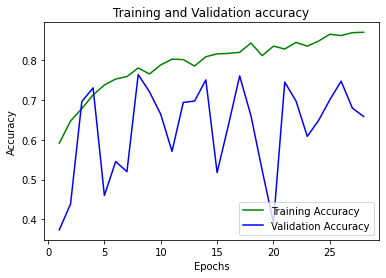

In [109]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
numEpochs = range(1,  28 + 1)
plt.plot(numEpochs, accuracy, 'g', label='Training Accuracy')
plt.plot(numEpochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

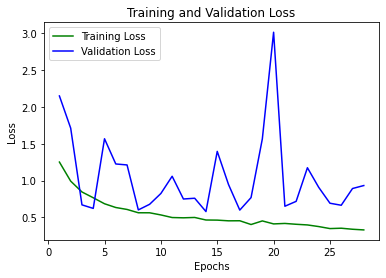

In [110]:
loss = history.history['loss']
val_loss = history.history['val_loss']
numEpochs = range(1,  28 + 1)
plt.plot(numEpochs, loss, 'g', label='Training Loss')
plt.plot(numEpochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Testing

In [111]:
model.load_weights("/content/drive/MyDrive/DatasetV2/model/checkpoints/model.h5")

In [112]:
predictions = np.array([])
labels =  np.array([])
for x, y in test_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

In [113]:
test_ds.class_names

['COVID-19', 'normal', 'pneumonia']

In [114]:
target_names  = ['COVID-19', 'normal', 'pneumonia']
print(classification_report(labels, predictions, target_names = target_names))

              precision    recall  f1-score   support

    COVID-19       0.89      0.74      0.81       200
      normal       0.69      0.93      0.79       200
   pneumonia       0.77      0.62      0.69       200

    accuracy                           0.77       600
   macro avg       0.78      0.77      0.76       600
weighted avg       0.78      0.77      0.76       600



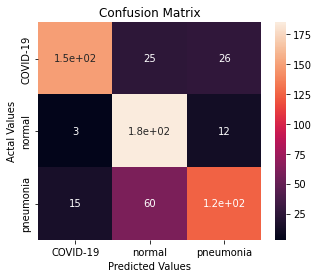

In [115]:
cm = confusion_matrix(labels, predictions)

cm_df = pd.DataFrame(cm,
                     index = target_names, 
                     columns = target_names)

plt.figure(figsize=(5,4))
sb.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()